Asynchronous Advantage Actor-Critic (A3C) Implementation

The provided code implements the Asynchronous Advantage Actor-Critic (A3C) algorithm, a type of reinforcement learning algorithm that uses multiple threads to train a model in parallel. A3C is an extension of the Actor-Critic algorithm, which combines policy-based and value-based methods.

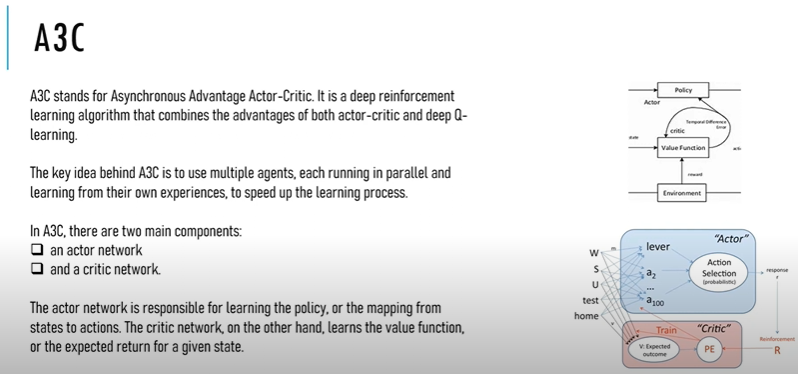

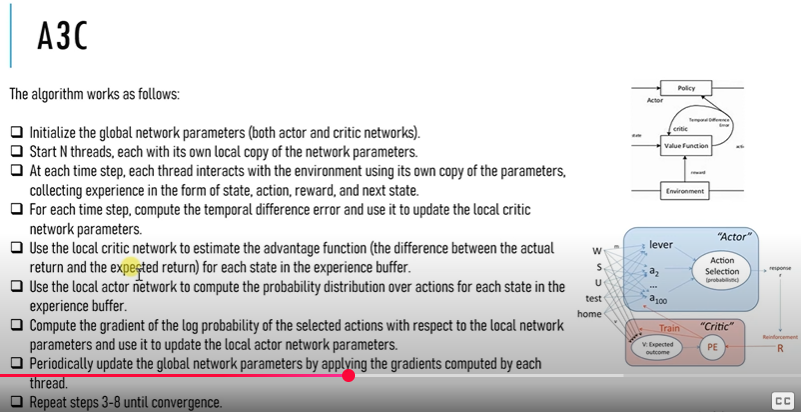

The Worker class is a subclass of threading.Thread, designed to run in parallel with other workers. Each worker:

Interacts with its own instance of an environment (via gym.make(env_name)).
Uses a local neural network (self.local_network) to select actions based on the current state.
Collects experiences (states, actions, rewards) during an episode.
Computes discounted rewards and updates the shared global model (self.global_model) using gradients computed from the local network.
Synchronizes its local network with the global model after each episode.

self.local_network.set_weights(self.global_model.get_weights()): Initializes the local network with the current weights of the global model to ensure all workers start with the same policy.

self.local_network.set_weights(self.global_model.get_weights()): Initializes the local network with the current weights of the global model to ensure all workers start with the same policy.

Action Selection:

The current state is fed into the local network to obtain logits (raw outputs before softmax).

tf.convert_to_tensor([state], dtype=tf.float32) converts the state to a TensorFlow tensor with a batch dimension 
([state] adds a dimension for batch processing).

The softmax output (logits.numpy()) gives a probability distribution over actions.

np.random.choice(action_size, p=np.squeeze(logits.numpy())) samples an action based on these probabilities, implementing a stochastic policy.

Environment Step:

The selected action is executed in the environment via self.env.step(action), returning:

next_state: The new state after the action.

reward: The immediate reward.

done: A boolean indicating whether the episode has ended.

_: Ignored info dictionary (common in Gym environments).

The total episode reward is accumulated (episode_reward += reward).

The state, action, and reward are stored in lists (episode_states, episode_actions, episode_rewards) for later use in training.

The state is updated to next_state for the next iteration.

Environment Step

The selected action is executed in the environment via self.env.step(action), returning:

next_state: The new state after the action.

reward: The immediate reward.

done: A boolean indicating whether the episode has ended.

_: Ignored info dictionary (common in Gym environments).

The total episode reward is accumulated (episode_reward += reward).

The state, action, and reward are stored in lists (episode_states, episode_actions, episode_rewards) for later use in training.

The state is updated to next_state for the next iteration.

Episode Termination (if done):

When the episode ends (done is True):

Compute discounted rewards using self.discounted_rewards(episode_rewards).

Update the global model using self.update_global(episode_states, episode_actions, discounted_rewards).

Synchronize the local network with the global model’s updated weights (self.local_network.set_weights(self.global_model.get_weights())).

Print the thread ID, episode number, and total episode reward for monitoring.

Episode Termination (if done

When the episode ends (done is True):

Compute discounted rewards using self.discounted_rewards(episode_rewards).

Update the global model using self.update_global(episode_states, episode_actions, discounted_rewards).

Synchronize the local network with the global model’s updated weights (self.local_network.set_weights(self.global_model.get_weights())).

Print the thread ID, episode number, and total episode reward for monitoring.

Note: The break statement ensures the loop exits after processing a completed episode, though it’s redundant here since done already controls the while loop.

In [ ]:
import gym
import numpy as np
import tensorflow as tf 
import threading

In [ ]:
num_threads = 4
max_episodes = 10000
gamma = .99
learning_rate = 0.01 
entropy_beta=0.01 

env_name ='CartPole-v1' 
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n 

In [ ]:
state_size 

4

In [ ]:
action_size  

2

In [6]:
global_model = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu', input_shape=(state_size,)),
                                   tf.keras.layers.Dense(action_size, activation='softmax')])
global_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy')

d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Units: 32 neurons (or units), meaning this layer transforms the input state into a 32-dimensional feature representation.

Feature Extraction: The hidden layer processes the raw state input to extract useful features or patterns. In RL, the state might contain variables like position or velocity, and the hidden layer learns to combine these into higher-level representations that are more informative for decision-making.

### DQN

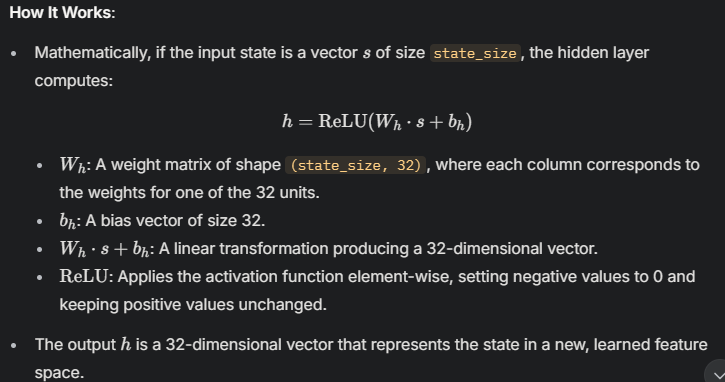

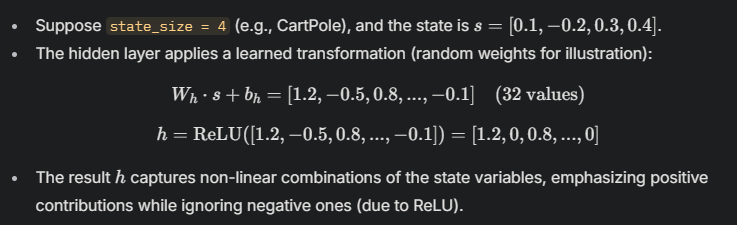

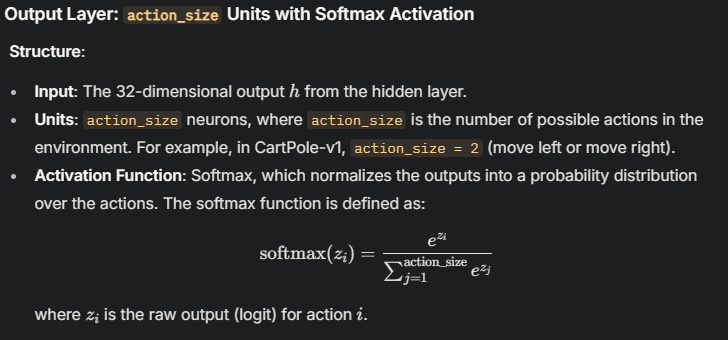

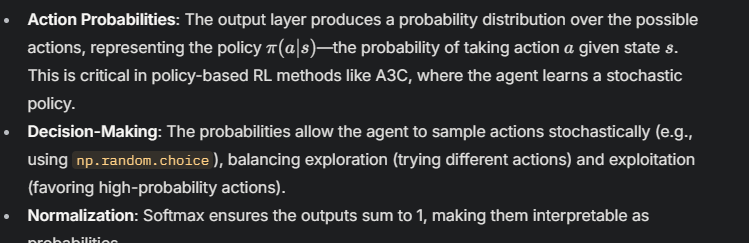

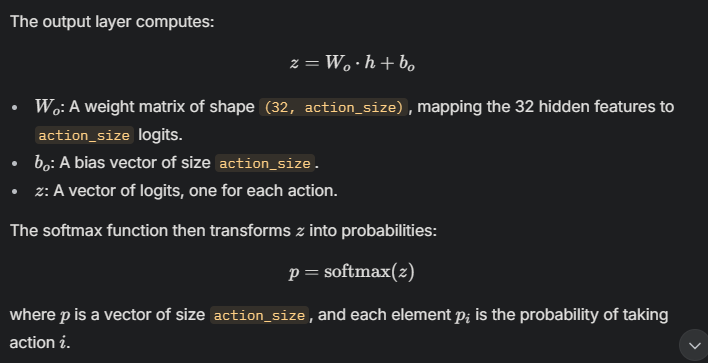

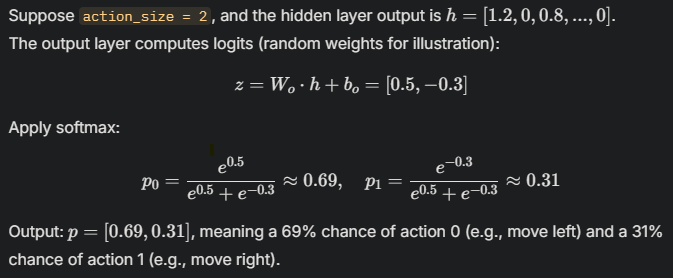

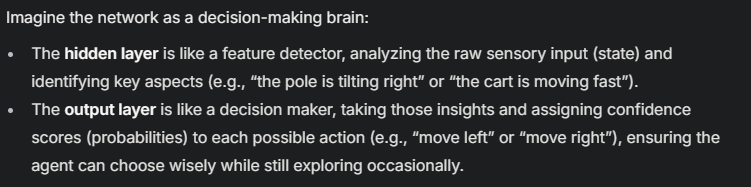

In [ ]:
class Worker(threading.Thread):
    def __init__(self, thread_id, global_model):
        super(Worker, self).__init__()
        self.thread_id = thread_id
        self.global_model = global_model
        self.env = gym.make(env_name)
        self.state_size = state_size
        self.action_size = action_size
        
      
        
#         A hidden layer with 32 units and ReLU activation, taking the state as input.
# An output layer with action_size units and softmax activation, producing a probability distribution over actions.
# This network is used to select actions and compute gradients locally.
   


        inputs = tf.keras.Input(shape=(state_size,))
        x = tf.keras.layers.Dense(32, activation='relu')(inputs)
        policy = tf.keras.layers.Dense(action_size, activation='softmax')(x)
        value = tf.keras.layers.Dense(1, activation='linear')(x)
        self.local_network = tf.keras.Model(inputs=inputs, outputs=[policy, value])
        self.local_network.set_weights(self.global_model.get_weights())
        
    def run(self):
        for episode in range(max_episodes):
            state = self.env.reset()[0]
            done = False
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_reward = 0
            
            while not done:
                logits = self.local_network(tf.convert_to_tensor([state], dtype=tf.float32))
                action = np.random.choice(action_size, p = np.squeeze(logits.numpy()))
                
                
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                
                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                
                state = next_state
                
                if done:
                    discounted_rewards = self.discounted_rewards(episode_rewards)
                    
                    self.update_global(episode_states, episode_actions, discounted_rewards)
                    self.local_network.set_weights(self.global_model.get_weights())
                    print("Thread:", self.thread_id, "Episode:", episode, "Reward:", episode_reward)
                    break
                    
    def discounted_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_total = 0
        for i in reversed(range(len(rewards))):
            running_total = running_total* gamma + rewards[i]
            discounted_rewards[i] = running_total
        return discounted_rewards


    def update_global(self, states, actions, discounted_rewards):
        with tf.GradientTape() as tape:
            total_loss = self.calculate_t_loss(states, actions, discounted_rewards)
        gradients = tape.gradient(total_loss, self.local_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.global_model.trainable_variables))

    def calculate_t_loss(self, states, actions, discounted_rewards):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)  # Fix: Use int32 for actions
        discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
        
        logits, values = self.local_network(states)  # Fix: Get both policy and value outputs
        probs = tf.nn.softmax(logits)
        
        cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(actions, logits, from_logits=True)
        policy_loss = tf.reduce_mean(cross_entropy * discounted_rewards)
        
        value_loss = tf.reduce_mean(tf.square(discounted_rewards - tf.squeeze(values)))
        
        entropy_loss = tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs + 1e-10), axis=1))
        total_loss = -policy_loss + 0.5 * value_loss - 0.01 * entropy_loss
        return total_loss

Purpose: Computes the discounted cumulative rewards (also known as returns) for an episode to assign credit to actions based on future rewards.

The A3C algorithm uses multiple threads to train the model in parallel. Each worker trains its local model independently and updates the global model's weights asynchronously. This allows the algorithm to explore different parts of the state space simultaneously, which can improve the model's performance.

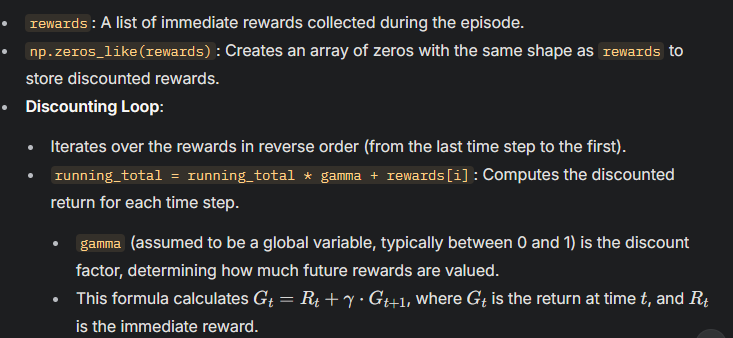

discounted_rewards[i] = running_total: Stores the computed return for the current time step.
Return: An array of discounted rewards, where each element represents the total expected return starting from that time step.

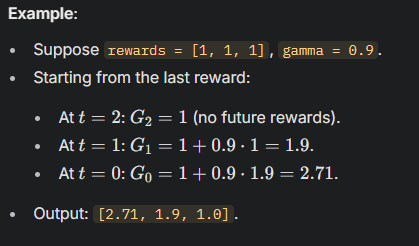

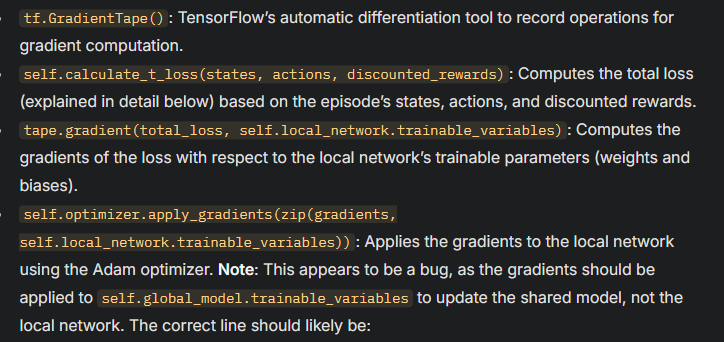

Purpose: Computes the total loss for an episode, combining policy loss, value loss, and entropy loss, which is used to update the model’s parameters.

Key Components:

Tensor Conversion:

Converts states, actions, and discounted_rewards to TensorFlow tensors with dtype=tf.float32 for compatibility with TensorFlow operations.

Note: Converting actions to tf.float32 is unusual since actions are typically integers in discrete action spaces. This might work due to TensorFlow’s casting behavior but could be clarified by ensuring actions remain integers (tf.int32).

Policy Loss:

logits = self.local_network(states): Feeds the states through the local network to get raw output logits (pre-softmax).

probs = tf.nn.softmax(logits): Applies softmax to convert logits into a probability distribution over actions.

cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(actions, logits, from_logits=True):

Computes the cross-entropy loss between the predicted logits and the chosen actions.

from_logits=True indicates that the input is raw logits, so the function applies softmax internally for the loss computation (avoiding numerical instability).

This measures how well the policy predicts the taken actions.

policy_loss = tf.reduce_mean(cross_entropy * discounted_rewards):

Multiplies the cross-entropy by the discounted rewards (acting as advantages or weights) to reinforce actions that led to higher returns.

The mean is taken over all time steps to get a single scalar loss.

This is the core of the policy gradient method, encouraging the model to increase the probability of actions that yield higher returns.

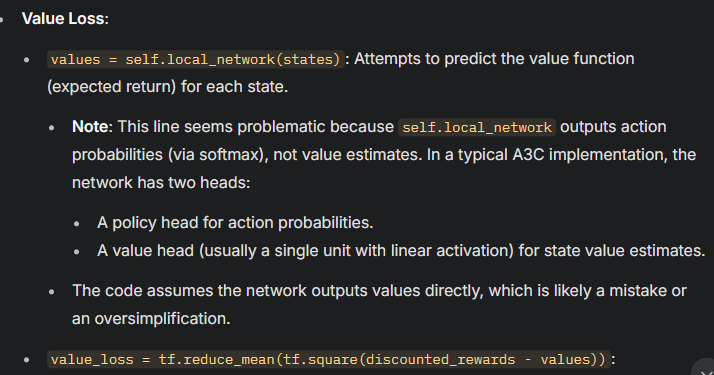

Computes the mean squared error between the predicted values and the actual discounted rewards (treated as target values).

This trains the value function to estimate the expected return from each state accurately.

If values is incorrectly derived from the policy head, this loss won’t function as intended.

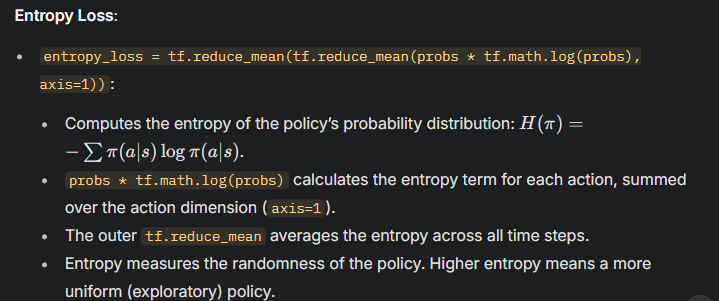

The entropy term is negated in the total loss (see below), so minimizing -entropy_loss encourages exploration by penalizing overly confident (low-entropy) policies.

In [8]:
workers = []
for i in range(num_threads):
    worker = Worker(i, global_model)
    workers.append(worker)
    
for worker in workers:
    worker.start()
    
for worker in workers:
    worker.join()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_15496\1162592690.py", line 31, in run
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\time_limit.py", line 50, in step
    observation, reward, terminated, truncated, info = self.env.step(action)
                                                       ^^^^^^^^^^^^^^^^^^^^^
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\order_enforcing.py", line 37, in step
    return self.env.step(action)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\env_checker.py", line 37, in step
Exception in thread Thread-5:
Traceback (most recent call last):
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\threading.py", line 1045, i